In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import norm
from scipy.optimize import fsolve
from itertools import product

In [2]:
# Price for zero coupon bond
def ZCbond(F, r, t, T):
    return F*np.exp(-r*(T-t))

In [5]:
def rpoi(a, y, lam, T):
    return np.exp(lam * T * (np.exp(a) - 1) - a * y)

## Compound Poisson Lognormal case

In [8]:
# MC with lognormal distribution for the size of losses
def naive_MC_log(nr = 20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.lognormal(mean=mu, sigma=sig, size = poissons[i]))
        h.append(int(x>D))
    return np.cumsum(h)/np.arange(1,nr+1)

In [14]:
def naive_MC_log_test(nr = 20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.lognormal(mean=mu, sigma=sig, size = poissons[i]))
        h.append(int(x>D))
    mean_estimte = np.mean(h)
    variance = np.var(h)/2
    return mean_estimte, variance

mean_estimate, variance = naive_MC_log_test(nr = 20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1)
print(f"{mean_estimate:>15.5f} | {variance:>10.7f}")

        0.03095 |  0.0149960


### IS with optimal parameters accourding to minimizing variance

In [17]:
def rlog(a, y, mu, sig, n):
    return np.exp(((mu+a)**2-mu**2)/(2*sig**2))**n / np.exp(a * y/(sig**2))

In [19]:
def g(b=0.07,lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    lhs = 2 * lam * T * b / sig**2 * np.exp(b**2 / (2 * sig**2))
    z = (np.log(D) - mu + b) / sig
    rhs = norm.pdf(z) / (sig * norm.sf(z))
    return lhs - rhs

def root_func(b):
        return g(b,lam=35,D=9e9,T=1, mu=18.4, sig=1)
    
a_log = fsolve(root_func, x0=0.05)[0]

print(f"Explicit solution for optimal b: {a_log}")

Explicit solution for optimal b: 0.06826480691146654


In [23]:
def MC_IS_log_poi_test(nr=20000, lam=35,D=9000000000,T=1, mu=18.4, sig=1):

    def root_func(b):
        return g(b, lam, D, T, mu, sig)
    
    # Initial variables
    a_log = fsolve(root_func, x0=0.05)[0]
    a_poi = a_log**2/(2*sig**2)
    poisson_means = lam * T * np.exp(a_poi)
    new_mu = mu+a_log

    # Preallocate memory
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_log = np.zeros(nr)
    
    # Loop over simulations
    for i in range(nr):
        poissons = np.random.poisson(lam=poisson_means)
        x = np.random.normal(loc=new_mu, scale=sig, size=poissons)
        y = np.sum(x)
        z = np.sum(np.exp(x))

        h[i] = int(z > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_log[i] = rlog(a_log, y, mu, sig, poissons)

    # Compute weighted values
    weighted_values = h * r_poi * r_log
    
    # Compute mean estimate
    mean_estimate = np.mean(weighted_values)
    
    # Compute variance of the estimator
    variance = np.var(weighted_values)/2

    return mean_estimate, variance

mean_estimate, variance = MC_IS_log_poi_test(nr=20000, lam=35,D=9000000000,T=1, mu=18.4, sig=1)
print(f"{mean_estimate:>15.5f} | {variance:>10.7f}")

        0.03004 |  0.0093203


In [27]:
# Importance sampling for default probability with explicit b
def MC_IS_log_poi(nr=20000, lam=35,D=9000000000,T=1, mu=18.4, sig=1):

    def root_func(b):
        return g(b, lam, D, T, mu, sig)
    
    # Initial variables
    a_log = fsolve(root_func, x0=0.05)[0]
    a_poi = a_log**2/(2*sig**2)
    poisson_means = lam * T * np.exp(a_poi)
    new_mu = mu+a_log

    # Preallocate memory for cumulative sums
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_log = np.zeros(nr)
    
    # Loop over the number of simulations
    for i in range(nr):
        # Generate Poisson-distributed count
        poissons = np.random.poisson(lam=poisson_means)

        # Generate the exponential random variables for this count
        # Directly sum them without creating large intermediate arrays
        x = np.random.normal(loc=new_mu, scale=sig, size=poissons)
        y = np.sum(x)
        z = np.sum(np.exp(x))

        # Compute h and r for this simulation
        h[i] = int(z > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_log[i] = rlog(a_log, y, mu, sig, poissons)

    # Calculate cumulative sum and return the average at each step
    cumulative_sum = np.cumsum(h * r_poi * r_log)
    cumulative_avg = cumulative_sum / np.arange(1, nr + 1)

    return cumulative_avg

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


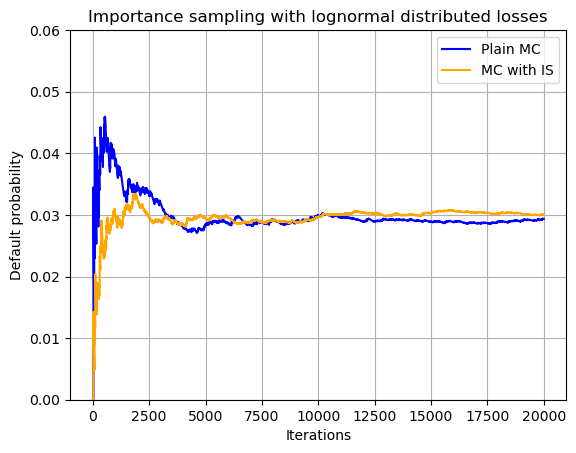

In [93]:
plt.plot(naive_MC_log(),color = "blue",label = "Plain MC")
plt.plot(MC_IS_log_poi(),color = "orange",label = "MC with IS")
plt.title("Importance sampling with lognormal distributed losses")
plt.ylim([0,0.06])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.savefig('IS_lognormal.eps', format='eps')
plt.show()

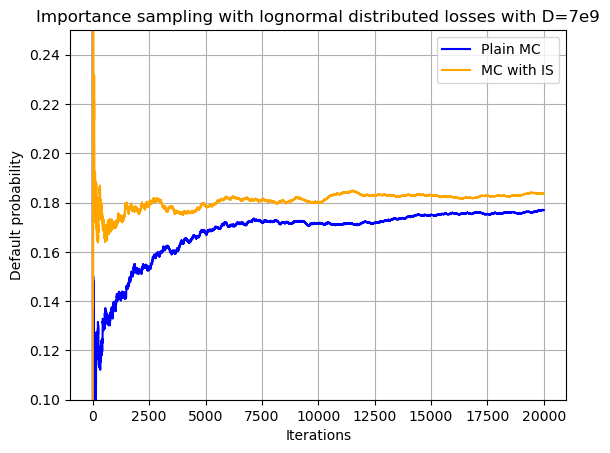

In [39]:
plt.plot(naive_MC_log(nr = 20000,lam=35,D=7e9,T=1, mu=18.4, sig=1),color = "blue",label = "Plain MC")
plt.plot(MC_IS_log_poi(nr = 20000,lam=35,D=7e9,T=1, mu=18.4, sig=1),color = "orange",label = "MC with IS")
plt.title("Importance sampling with lognormal distributed losses with D=7e9")
plt.ylim([0.1,0.25])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.show()

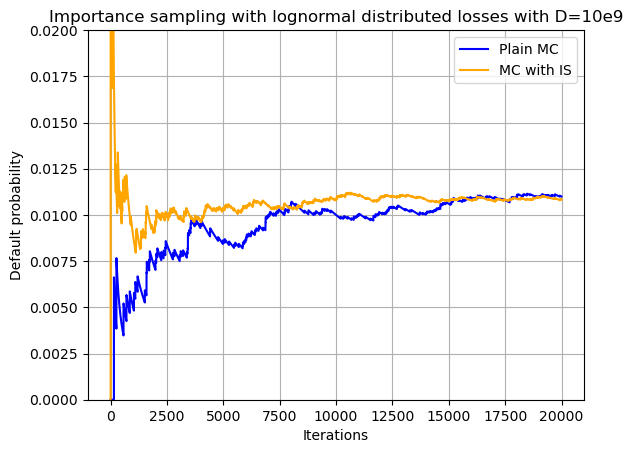

In [55]:
plt.plot(naive_MC_log(nr = 20000,lam=35,D=10000000000,T=1, mu=18.4, sig=1),color = "blue",label = "Plain MC")
plt.plot(MC_IS_log_poi(nr = 20000,lam=35,D=10000000000,T=1, mu=18.4, sig=1),color = "orange",label = "MC with IS")
plt.title("Importance sampling with lognormal distributed losses with D=10e9")
plt.ylim([0,0.02])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.show()

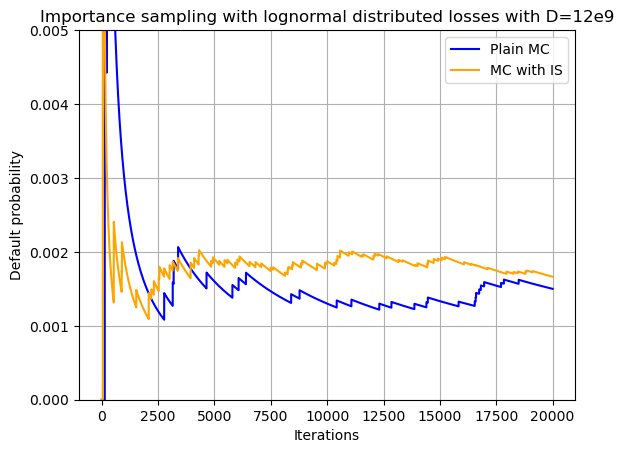

In [61]:
plt.plot(naive_MC_log(nr = 20000,lam=35,D=12e9,T=1, mu=18.4, sig=1),color = "blue",label = "Plain MC")
plt.plot(MC_IS_log_poi(nr = 20000,lam=35,D=12e9,T=1, mu=18.4, sig=1),color = "orange",label = "MC with IS")
plt.title("Importance sampling with lognormal distributed losses with D=12e9")
plt.ylim([0,0.005])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.show()